In [380]:
import pandas as pd
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset,DataLoader
from torchsummary import summary
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [381]:
device = 'cuda' if  torch.cuda.is_available() else 'cpu'

In [382]:
device

'cpu'

In [383]:
df = pd.read_csv('heart.csv')
df.head(3)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0


In [384]:
encoded_df = pd.get_dummies(df,columns=['Sex','ChestPainType','RestingECG','MaxHR','ExerciseAngina','ST_Slope']).astype(int)

In [385]:
encoded_df.head(2)

,Age,RestingBP,Cholesterol,FastingBS,Oldpeak,HeartDisease,Sex_F,Sex_M,ChestPainType_ASY,ChestPainType_ATA,...,MaxHR_190,MaxHR_192,MaxHR_194,MaxHR_195,MaxHR_202,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,0,0,0,1,0,1,...,0,0,0,0,0,1,0,0,0,1
1,49,160,180,0,1,1,1,0,0,0,...,0,0,0,0,0,1,0,0,1,0


In [386]:
X_train,X_temp,Y_train,Y_temp = train_test_split(encoded_df.drop('HeartDisease',axis=1),encoded_df['HeartDisease'],test_size=.4,random_state=69)
X_val,X_test,Y_val,Y_test = train_test_split(X_temp,Y_temp,test_size=.5,random_state=69)

In [387]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [388]:
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [389]:
class dataset(Dataset):
    def __init__(self,X,Y):
        self.X = torch.tensor(X,dtype=torch.float32).to(device)
        self.Y = torch.tensor(Y,dtype=torch.float32).to(device)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        return self.X[index],self.Y[index]

In [390]:
train_dataset = dataset(X_train_scaled,Y_train.values)
val_dataset = dataset(X_valid_scaled,Y_val.values)
test_dataset = dataset(X_test_scaled,Y_test.values)

In [391]:
train_dataloader = DataLoader(train_dataset,batch_size=32,shuffle=True)
val_dataloader = DataLoader(val_dataset,batch_size=32,shuffle=True)
test_dataloader = DataLoader(test_dataset,batch_size=32,shuffle=True)

In [392]:
HIDDEN_NEURON = 50
class MyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_layer = nn.Linear(encoded_df.drop('HeartDisease',axis=1).shape[1],HIDDEN_NEURON)
        self.linear = nn.Linear(HIDDEN_NEURON,1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self,x):
        x = self.input_layer(x)
        x = self.linear(x)
        x = self.sigmoid(x)
        return x
    
        

In [393]:
model = MyModel().to(device)

In [394]:
summary(model,(encoded_df.drop('HeartDisease',axis=1).shape[1],))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 50]           6,950
            Linear-2                    [-1, 1]              51
           Sigmoid-3                    [-1, 1]               0
Total params: 7,001
Trainable params: 7,001
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.03
Estimated Total Size (MB): 0.03
----------------------------------------------------------------


In [395]:
criterion =nn.BCELoss()
optimazer = Adam(model.parameters(),lr=1e-3)

In [396]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []


In [397]:
epochs=10
for epoch in range(epochs):
    total_acc_train = 0
    total_loss_train = 0
    total_acc_validation = 0
    total_loss_validation = 0

    for data in train_dataloader:
        inputs, labels = data

        prediction = model(inputs).squeeze(1)

        batch_loss = criterion(prediction,labels)

        total_loss_train += batch_loss.item()

        acc = (prediction.round() == labels).sum().item()
        total_acc_train += acc

        
        batch_loss.backward()
        optimazer.step()
        optimazer.zero_grad()

    with torch.no_grad():
        for validation in val_dataloader:
            inputs  ,labels=validation

            prediction=model(inputs).squeeze(1)
            batch_loss = criterion(prediction,labels)
            total_loss_validation += batch_loss.item()

            acc = (prediction.round()==labels).sum().item()

            total_acc_validation += acc
    
    total_loss_train_plot.append(round(total_loss_train/train_dataset.__len__(),4))
    total_loss_validation_plot.append(round(total_loss_validation/val_dataset.__len__(),4))

    total_acc_train_plot.append(round(total_acc_train/train_dataset.__len__()*100,4))
    total_acc_validation_plot.append(round(total_acc_validation/val_dataset.__len__()*100,4))

    print(f'Epoch no.{epoch+1} Train Loss: {total_loss_train_plot[epoch]} Train Accuracy: {total_acc_train_plot[epoch]}')
    print(f'Epoch no.{epoch+1} Validation Loss: {total_loss_validation_plot[epoch]} Validation Accuracy: {total_acc_validation_plot[epoch]}')
    print('='*50)

Epoch no.1 Train Loss: 0.0219 Train Accuracy: 65.8182
Epoch no.1 Validation Loss: 0.0202 Validation Accuracy: 82.6087
Epoch no.2 Train Loss: 0.0196 Train Accuracy: 79.4545
Epoch no.2 Validation Loss: 0.0178 Validation Accuracy: 84.2391
Epoch no.3 Train Loss: 0.0171 Train Accuracy: 84.9091
Epoch no.3 Validation Loss: 0.0155 Validation Accuracy: 84.7826
Epoch no.4 Train Loss: 0.0148 Train Accuracy: 86.0
Epoch no.4 Validation Loss: 0.0134 Validation Accuracy: 85.3261
Epoch no.5 Train Loss: 0.013 Train Accuracy: 86.7273
Epoch no.5 Validation Loss: 0.012 Validation Accuracy: 85.3261
Epoch no.6 Train Loss: 0.0117 Train Accuracy: 87.2727
Epoch no.6 Validation Loss: 0.0113 Validation Accuracy: 84.2391
Epoch no.7 Train Loss: 0.0117 Train Accuracy: 87.8182
Epoch no.7 Validation Loss: 0.0113 Validation Accuracy: 84.7826
Epoch no.8 Train Loss: 0.0106 Train Accuracy: 87.8182
Epoch no.8 Validation Loss: 0.0112 Validation Accuracy: 84.2391
Epoch no.9 Train Loss: 0.0102 Train Accuracy: 87.8182
Epoch n

In [398]:
model.eval()
with torch.no_grad():
    total_loss_test =0
    total_acc_test = 0
    for data in test_dataloader:
        inputs,labels = data

        prediction = model(inputs).squeeze(1)

        batch_loss_test = criterion(prediction,labels).item()
        total_loss_test +=batch_loss_test
        
        acc = (prediction.round() == labels).sum().item()

        total_acc_test+= acc

    print(f'Accuracy for TestSet:{round(total_acc_test/test_dataset.__len__()*100,4)}')


Accuracy for TestSet:85.8696


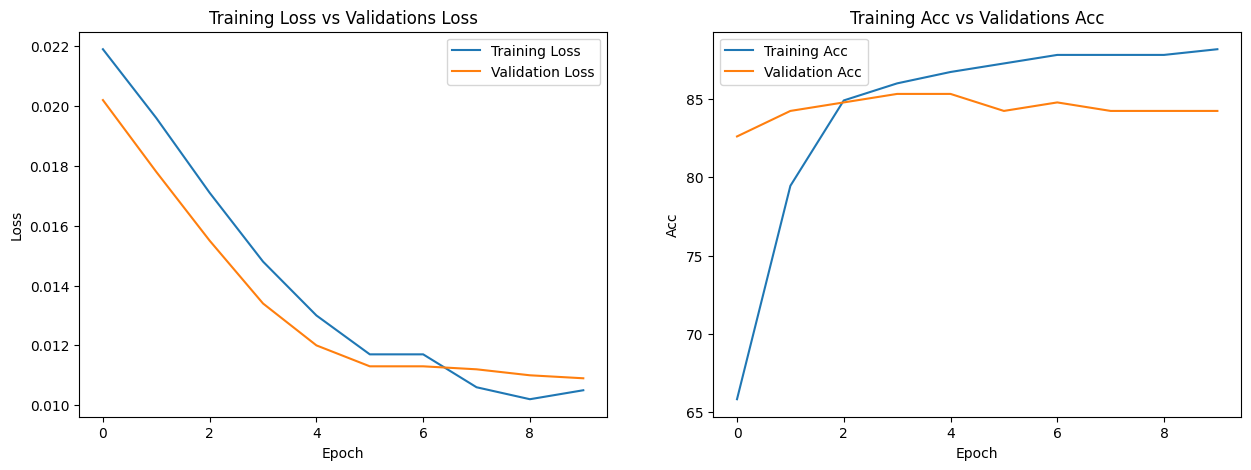

In [399]:
fig,axs=  plt.subplots(nrows=1,ncols=2,figsize=(15,5))
axs[0].plot(total_loss_train_plot,label = 'Training Loss')
axs[0].plot(total_loss_validation_plot,label='Validation Loss')
axs[0].set_title('Training Loss vs Validations Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(total_acc_train_plot,label = 'Training Acc')
axs[1].plot(total_acc_validation_plot,label='Validation Acc')
axs[1].set_title('Training Acc vs Validations Acc')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Acc')
axs[1].legend()